# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
from models import *

from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
from prettytable import PrettyTable
import torch
import torch.optim
from skimage.measure import compare_psnr
from skimage.measure import compare_ssim

from utils.demosaicing_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
# dim_div_by = 64
dataTable = PrettyTable(['Iteration', 'Loss', 'PSNR'])
pattern='rggb'

# Choose Image

In [2]:
fname='data/moire/000001.png' 

# Load image and Mosaicing

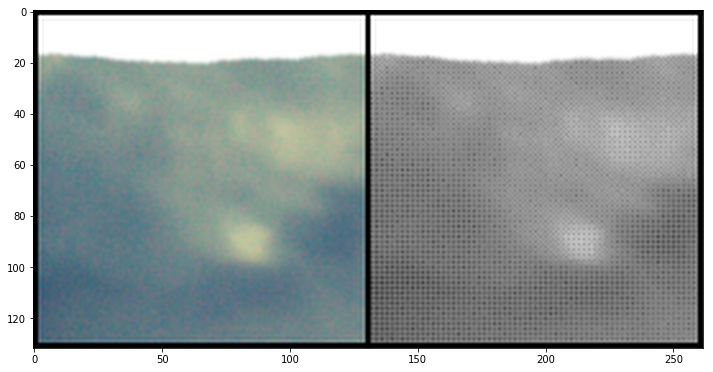

In [3]:
img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_np = pil_to_np(img_pil)
im=img_np.transpose(1,2,0)

img_bayer_np = bayer_mosaic(img_np,pattern)      # converting to bayer mosaic
img_bayer_pil = np_to_pil(img_bayer_np)                # converting to PIL image
img_bayer_pil.save('bayer.png')

if PLOT:
    plot_image_grid([img_np,img_bayer_np], 3,10 )

# Set up parameters and Net

In [4]:
pad =  'reflection' 
OPT_OVER = 'net'
OPTIMIZER = 'adam'
# tv_weight = 1e-8
# Same params and net as in super-resolution and denoising
INPUT = 'noise'
input_depth = 32
LR = 0.01
num_iter = 1800
param_noise = False
show_every = 50
figsize = 8
reg_noise_std = 0

net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128]*5, 
               num_channels_up   = [128]*5,
               num_channels_skip = [128]*5,
               filter_size_up = 3, filter_size_down = 3,
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

# No of Parameters

In [5]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_bayer_np).type(dtype)


Number of params: 3002627


# Main Loop

Starting optimization with ADAM


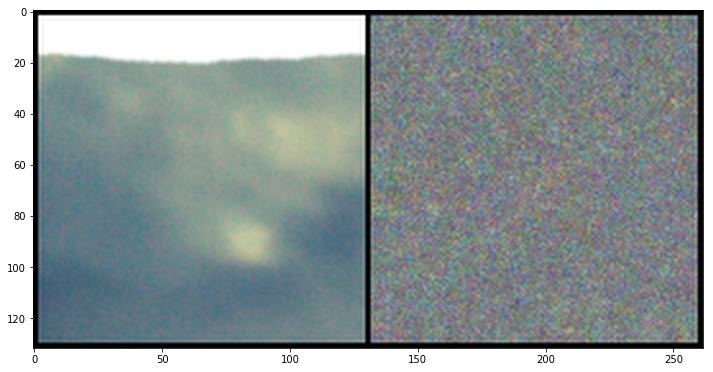

In [ ]:
i = 0
x=list()
y=list()
z=list()


def closure():
    
    global i, x , y, z
            
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
    out = net(net_input)
    bayer = bayer_mosaic_torch(out, dtype,pattern)
   
    total_loss = mse(bayer , mask_var)
#     if tv_weight > 0:
#         total_loss += tv_weight * tv_loss(out)
    total_loss.backward()
    
    psnr = compare_psnr(img_np, torch_to_np(out))
        
    print ('Iteration %05d    Loss %f     PSNR %.3f' % (i, total_loss.item(), psnr), '\r', end='')
    dataTable.add_row([ i, total_loss.item(),psnr])
    x.append(i)
    y.append(psnr)
    z.append(total_loss.item())
   
    
    if  PLOT and i % show_every == 0:
        
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(img_np,0,1), np.clip(out_np, 0, 1)], factor=10, nrow=2)
    
    
    i += 1
    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

time_start = time.clock()
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)
time_elapsed = (time.clock() - time_start)

In [ ]:
out_np = torch_to_np(net(net_input))
plot_image_grid([img_np,  out_np ,np.abs(img_np-out_np)], factor=20);
out_b=out_np.transpose(1,2,0)

# print ('SSIM : %f   ' %  (compare_ssim(im, out_b, win_size=7, multichannel=True)))

out = np_to_pil(out_np)
out.save('image.png')

In [ ]:
plt.plot(x,y)
plt.xlabel('Iteration')
plt.ylabel('PSNR')
plt.title('PSNR graph')
# plt.ylim(25.0,30.0)
# plt.rcParams["figure.figsize"]=(20,10)

plt.grid(True, linestyle = '-.')
plt.tick_params(labelcolor= 'r', labelsize='large', width=5)
plt.show()

In [ ]:
plt.plot(x,z)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss graph')
plt.ylim(0.0000,0.00035)
# plt.rcParams["figure.figsize"]=(20,10)

plt.grid(True, linestyle = '-.')
plt.tick_params(labelcolor= 'r', labelsize='large', width=5)
plt.show()

In [ ]:
print(dataTable)

In [ ]:
print ('SSIM for last image : %f   ' %  (compare_ssim(im, out_b, win_size=7, multichannel=True)))
print("Maximum PSNR is {0}    at ITERATION -- %i".format(max(y))  %y.index(max(y)))
print("Maximum PSNR with Loss -- %f\n" %z[y.index(max(y))])

print("Minimum Loss is {0}    at ITERATION -- %i".format(min(z))  %z.index(min(z)))
print("Minimum Loss with PSNR -- %f\n" %y[z.index(min(z))])

print('Time for optimization: %f min' %(time_elapsed/60))